# Training and testing model

### Importing relevant Libararies, Objects and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(".."))

from sklearn.metrics import confusion_matrix #Add confusion matrix later

from src.train import TrainingAlgorithm, evaluate
from src.model import model
from src.utils import load_train_val_loaders

### Training Model

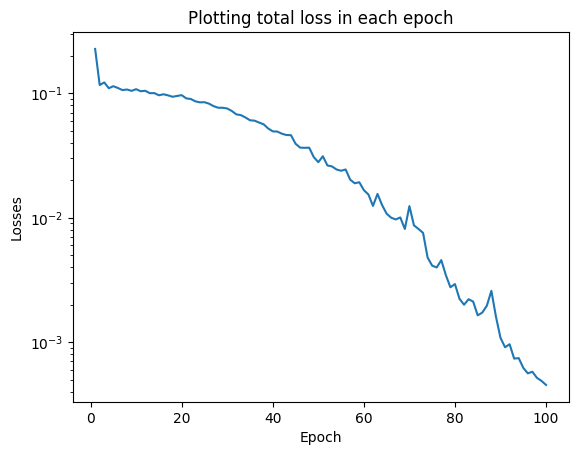

In [2]:
train_loader, val_loader = load_train_val_loaders("data")

m = model()
losses = TrainingAlgorithm(m, train_loader, num_epochs=100, device="cpu") 

epochs = np.arange(1, len(losses)+1)

plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.yscale("log")
plt.plot(epochs, losses)
plt.title("Plotting total loss in each epoch")
plt.show()

### Testing on Validation Set

In [3]:
val_loss, val_acc = evaluate(m, val_loader)
print("Val loss:", val_loss)
print("Val accuracy:", val_acc)

Val loss: 0.7759170001372695
Val accuracy: 0.9335
